<font color=#8F00FF><h3 > Sberbank Russian Housing Market <h3></font>

In [133]:
"""
Lets import all the libraries needed for our code
"""

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score   
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import xgboost as xgb
from math import sqrt
from scipy.stats import norm, skew 
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import ElasticNet
from sklearn import linear_model
from scipy import stats
import os
print(os.listdir("../input"))

['BAD_ADDRESS_FIX.xlsx', 'train.csv', 'sample_submission.csv', 'test.csv', 'macro.csv']


<font color=#8F00FF>Lets Explore and see some Basic details about our dataset</font>

In [134]:
"""
Reading file from the specific folder
"""
train=pd.read_csv("../input/train.csv", parse_dates=['timestamp'])
print("Shape of dataset",train.shape,"\n")
print("Basic information of our data",train.info(),"\n")
print("Basic view of our rows",train.head())
test=pd.read_csv("../input/test.csv", parse_dates=['timestamp'])
macro_cols = ["balance_trade", "balance_trade_growth", "eurrub", "average_provision_of_build_contract",
"micex_rgbi_tr", "micex_cbi_tr", "deposits_rate", "mortgage_value", "mortgage_rate",
"income_per_cap", "rent_price_4+room_bus", "museum_visitis_per_100_cap", "apartment_build"]
macro = pd.read_csv("../input/macro.csv", parse_dates=['timestamp'], usecols=['timestamp'] + macro_cols)


Shape of dataset (30471, 292) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30471 entries, 0 to 30470
Columns: 292 entries, id to price_doc
dtypes: datetime64[ns](1), float64(119), int64(157), object(15)
memory usage: 67.9+ MB
Basic information of our data None 

Basic view of our rows    id  timestamp    ...      market_count_5000  price_doc
0   1 2011-08-20    ...                      4    5850000
1   2 2011-08-23    ...                     14    6000000
2   3 2011-08-27    ...                     10    5700000
3   4 2011-09-01    ...                      3   13100000
4   5 2011-09-05    ...                     14   16331452

[5 rows x 292 columns]


In [135]:
test.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,...,cafe_count_3000,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000
0,30474,2015-07-01,39.0,20.7,2,9,1,1998.0,1,8.9,3.0,Investment,Juzhnoe Butovo,2.615514e+07,178264,0.137846,0.041116,14080,11926.0,11,14892,24750.0,13,1,NaN,1,0,13,4,no,0,4,4,no,no,no,no,no,no,no,...,12,781.82,1227.27,1004.55,1,2,2,7,0,0,0,1,3,1,0,7,0,21.58,4.69,1,37550,8,299166,19,676.47,1088.24,882.35,2,5,4,8,0,0,0,1,10,1,0,14,1
1,30475,2015-07-01,79.2,NaN,8,17,1,0.0,3,1.0,1.0,OwnerOccupier,Poselenie Vnukovskoe,2.553630e+07,4001,0.496315,0.007122,275,NaN,0,264,NaN,0,0,NaN,0,0,0,0,no,0,1,0,no,no,no,no,no,no,no,...,10,680.00,1200.00,940.00,0,1,6,2,1,0,0,1,5,0,0,7,0,39.10,7.70,2,177300,6,231300,20,733.33,1250.00,991.67,2,4,8,4,1,1,0,2,11,0,1,12,1
2,30476,2015-07-01,40.5,25.1,3,5,2,1960.0,2,4.8,2.0,Investment,Perovo,9.946335e+06,139322,0.065409,0.225825,6400,2232.0,7,6558,7966.0,7,0,1548.0,3,0,13,0,no,0,2,7,yes,no,yes,yes,no,no,no,...,37,608.33,1069.44,838.89,1,8,19,7,2,0,0,2,3,0,5,22,4,25.62,13.59,27,427889,26,1024431,179,668.97,1132.18,900.57,5,53,64,42,11,4,0,10,21,0,10,71,11
3,30477,2015-07-01,62.8,36.0,17,17,1,2016.0,2,62.8,3.0,OwnerOccupier,Poselenie Voskresenskoe,2.149409e+07,7122,0.262459,0.017647,489,NaN,0,469,NaN,0,0,NaN,0,0,0,2,no,0,0,0,no,no,no,no,no,no,no,...,1,300.00,500.00,400.00,0,1,0,0,0,0,0,0,4,0,0,0,0,24.25,1.66,0,0,0,0,5,1560.00,2500.00,2030.00,0,1,0,1,1,2,0,0,10,0,0,2,0
4,30478,2015-07-01,40.0,40.0,17,17,1,0.0,1,1.0,1.0,OwnerOccupier,Poselenie Vnukovskoe,2.553630e+07,4001,0.496315,0.007122,275,NaN,0,264,NaN,0,0,NaN,0,0,0,0,no,0,1,0,no,no,no,no,no,no,no,...,9,700.00,1222.22,961.11,0,1,5,2,1,0,0,1,4,0,0,6,0,35.62,6.96,1,117300,4,201300,20,747.37,1263.16,1005.26,1,4,8,5,1,1,0,2,12,0,1,11,1


In [136]:
df = pd.concat([train, test])
df = pd.merge_ordered(df, macro, on='timestamp', how='left')

print(df.shape)

(38133, 305)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [137]:
df.head()

,0_13_all,0_13_female,0_13_male,0_17_all,0_17_female,0_17_male,0_6_all,0_6_female,0_6_male,16_29_all,16_29_female,16_29_male,7_14_all,7_14_female,7_14_male,ID_big_road1,ID_big_road2,ID_bus_terminal,ID_metro,ID_railroad_station_avto,ID_railroad_station_walk,ID_railroad_terminal,additional_education_km,additional_education_raion,area_m,basketball_km,big_church_count_1000,big_church_count_1500,big_church_count_2000,big_church_count_3000,big_church_count_500,big_church_count_5000,big_church_km,big_market_km,big_market_raion,big_road1_1line,big_road1_km,big_road2_km,build_count_1921-1945,build_count_1946-1970,...,trc_count_1000,trc_count_1500,trc_count_2000,trc_count_3000,trc_count_500,trc_count_5000,trc_sqm_1000,trc_sqm_1500,trc_sqm_2000,trc_sqm_3000,trc_sqm_500,trc_sqm_5000,ts_km,ttk_km,university_km,university_top_20_raion,water_1line,water_km,water_treatment_km,work_all,work_female,work_male,workplaces_km,young_all,young_female,young_male,zd_vokzaly_avto_km,balance_trade,balance_trade_growth,eurrub,average_provision_of_build_contract,micex_rgbi_tr,micex_cbi_tr,deposits_rate,mortgage_value,mortgage_rate,income_per_cap,rent_price_4+room_bus,museum_visitis_per_100_cap,apartment_build
0,18654,8945,9709,23603,11317,12286,9576,4677,4899,17508,8083,9425,10309,4846,5463,1,5,1,1,1,1.0,101,0.947962,3,6.407578e+06,3.516513,1,1,1,2,0,13,0.625783,10.814172,no,no,1.422391,3.830951,0.0,0.0,...,3,9,19,23,0,52,55600,171420,1244891,1419204,0,4036616,4.308127,10.918587,6.715026,0,no,0.992631,23.683460,98207,45930,52277,0.884350,21154,10147,11007,14.231961,15.459,10.1,41.7681,5.76,131.16,204.78,4.1,323275,11.84,42688.6,136.11,1240.0,23587.0
1,13729,6800,6929,17700,8702,8998,6880,3414,3466,15164,7593,7571,7759,3850,3909,2,4,2,2,2,2.0,32,1.072315,1,9.589337e+06,1.161579,1,1,1,1,0,15,0.967821,6.910568,no,no,2.887377,3.103996,1.0,143.0,...,5,7,8,14,0,40,94065,127065,179065,491565,0,2034942,0.725560,3.103996,1.852560,0,no,0.698081,1.317476,70194,34572,35622,0.686252,15727,7802,7925,9.242586,15.459,10.1,41.7537,5.76,131.45,204.92,4.1,323275,11.84,42688.6,136.11,1240.0,23587.0
2,11252,5336,5916,14884,7063,7821,5879,2784,3095,19401,10356,9045,6207,2938,3269,3,4,3,3,3,3.0,5,0.391957,1,4.808270e+06,1.952771,0,0,0,0,0,11,3.178751,5.752368,no,no,0.647250,2.927487,0.0,246.0,...,0,1,7,7,0,35,0,2600,52550,52550,0,1572990,3.562188,2.927487,0.841254,0,no,0.468265,4.912660,63388,31575,31813,1.510089,13028,6193,6835,9.540544,15.459,10.1,41.7114,5.76,131.08,204.84,4.1,323275,11.84,42688.6,136.11,1240.0,23587.0
3,24934,12152,12782,32063,15550,16513,13087,6442,6645,3292,1842,1450,13670,6544,7126,1,17,1,4,4,4.0,83,0.892674,6,1.258354e+07,4.923843,0,1,1,1,0,4,1.031777,27.892717,no,no,2.677824,2.780449,24.0,40.0,...,6,7,7,12,0,22,80780,89492,89492,205756,0,942180,0.583025,14.606501,10.903161,0,no,1.200336,15.623710,120381,60341,60040,0.622272,28563,13883,14680,17.478380,15.386,10.1,41.4014,5.76,131.45,205.42,4.0,386388,11.92,40311.3,155.22,1240.0,23587.0
4,11631,5408,6223,15237,7124,8113,5706,2724,2982,5164,2581,2583,6748,3084,3664,4,10,4,5,113,5.0,113,0.810801,2,8.398461e+06,0.307915,7,18,35,70,1,135,0.378756,9.155057,no,no,1.721834,3.133531,114.0,146.0,...,3,9,17,60,1,114,158200,445900,564843,2296870,45000,3503058,2.609420,1.721834,0.991683,2,no,0.820294,10.683540,68043,33807,34236,0.892668,13368,6209,7159,1.595898,15.386,10.1,41.5902,5.76,131.19,198.24,4.0,386388,11.92,40311.3,155.22,1240.0,23587.0


In [138]:
print(pd.set_option("display.max_rows",999))

print("Basic description of our data ",df.describe())

None
Basic description of our data             0_13_all       ...         apartment_build
count  38133.000000       ...            27232.000000
mean    9922.728031       ...            44910.638807
std     7268.372894       ...             3854.550878
min      322.000000       ...            23587.000000
25%     3255.000000       ...            46080.000000
50%     9633.000000       ...            46080.000000
75%    13682.000000       ...            46352.000000
max    36035.000000       ...            46352.000000

[8 rows x 289 columns]


In [139]:
"""
Lets check how many null values are present in our dataset
"""
null_columns=df.columns[df.isnull().any()]

df[null_columns].isnull().sum()

ID_railroad_station_walk                    59
build_count_1921-1945                     6209
build_count_1946-1970                     6209
build_count_1971-1995                     6209
build_count_after_1995                    6209
build_count_before_1920                   6209
build_count_block                         6209
build_count_brick                         6209
build_count_foam                          6209
build_count_frame                         6209
build_count_mix                           6209
build_count_monolith                      6209
build_count_panel                         6209
build_count_slag                          6209
build_count_wood                          6209
build_year                               14654
cafe_avg_price_1000                       7746
cafe_avg_price_1500                       5020
cafe_avg_price_2000                       2149
cafe_avg_price_3000                       1173
cafe_avg_price_500                       16440
cafe_avg_pric

<font color=#8F00FF>Since we saw there are so many null values lets try and handle them </font>

In [140]:
"""
Lets fetch Year column from our Transaction timestamp 
"""
df["trans_year"]=df.timestamp.dt.year

month_year = (df.timestamp.dt.month + df.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
df['month_year_cnt'] = month_year.map(month_year_cnt_map)

# Add week-year count
week_year = (df.timestamp.dt.weekofyear + df.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
df['week_year_cnt'] = week_year.map(week_year_cnt_map)

# Add month and day-of-week
df['month'] = df.timestamp.dt.month
df['dow'] = df.timestamp.dt.dayofweek

# Remove timestamp column (may overfit the model in train)
df.drop(['timestamp'], axis=1, inplace=True)


In [141]:
#df[df.build_year>300].build_year.min()

df=df[df.build_year!=20052009.0]
df.build_year=np.where(df.build_year<1691, np.nan,df.build_year)

In [142]:
"""
Lets replace NULL values in Buildyear as mean of the build_year in that subarea
"""
df.build_year = df.groupby(["sub_area"])['build_year'].apply(lambda x: x.fillna(x.mean()))
df["build_year"]=df["build_year"].astype("int64")
print("Lets see count of null value left in build_year now ",df.build_year.isnull().sum())

Lets see count of null value left in build_year now  0


In [143]:
#Even after replacement with mean we have build_year as zero which is quite irrelevant 
#hence without any groupping lets replace these values with mean


df.build_year=np.where(df.build_year<1691, np.nan,df.build_year)
df.build_year.fillna(df.build_year.mean(),inplace=True)

In [144]:
df.build_year.isnull().sum()

0

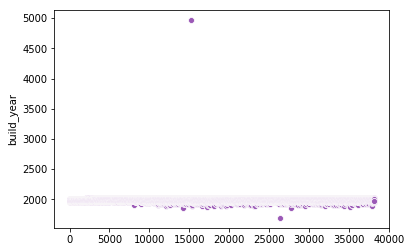

In [145]:
sns.scatterplot(df.index,df.build_year)

In [146]:
"""
Lets replace NULL values in max_floor as mean of the max_floor in that subarea
"""
df.max_floor = df.groupby(["sub_area"])['max_floor'].apply(lambda x: x.fillna(x.mean()))
df["max_floor"]=df["max_floor"].astype("int64")
print("Lets see count of null value left in max_floor now ",df.max_floor.isnull().sum())



Lets see count of null value left in max_floor now  0


In [147]:
"""
Lets create bins as per building size
"""
bins=[-1,0,1,2,5,10,50,120]
labels=["Single storey","One floor","Only 2 floor","2-5 floor","6-10 floors","11-50 floors","50+ floors"]

df["build_size"]=pd.cut(df["max_floor"],bins,labels=labels)
"""
Lets convert the build_size as object type
"""
df["build_size"]=df["build_size"].astype("object")
print("Build size column overview \n",df["build_size"].head())

train["build_size"]=pd.cut(train["max_floor"],bins,labels=labels)
train["build_size"]=train["build_size"].astype("object")

Build size column overview 
 0    11-50 floors
1    11-50 floors
2    11-50 floors
3    11-50 floors
4     6-10 floors
Name: build_size, dtype: object


In [148]:
"""
Lets create a column that tells the age of the building
"""
df["Building_Age"]=0
df["Building_Age"] = df["build_year"].apply(lambda x: 2019-x)
print ("Building age overview \n",df["Building_Age"].head())
df["Building_Age"]=df["Building_Age"].astype("int64")



Building age overview 
 0    41.0
1    17.0
2    46.0
3    15.0
4    62.0
Name: Building_Age, dtype: float64


In [149]:
"""
Lets create a column that tells the type as per the age of the building
"""
bins=[0,2,5,10,20,50,100,500]
labels=["2017-18","2017-2014","2014-2009","2009-1999","1999-1969","1969-1919","1919& before"]
df["building_agetype"]=pd.cut(df["Building_Age"],bins,labels=labels)
df["building_agetype"]=df["building_agetype"].astype("object")

print ("Building age overview \n",df["building_agetype"].head())


Building age overview 
 0    1999-1969
1    2009-1999
2    1999-1969
3    2009-1999
4    1969-1919
Name: building_agetype, dtype: object


In [150]:
"""
Lets try to replace max_floor on the basis of subarea groupped mean's
"""

df.floor = df.groupby(["sub_area"])['floor'].apply(lambda x: x.fillna(x.mean()))
print ("Lets see count of null value left in max_floor now ",df.floor.isnull().sum())

Lets see count of null value left in max_floor now  0


In [151]:
"""
Lets try to replace max_floor on the basis of subarea and build year groupped mean's
"""
df.max_floor = df.groupby(["sub_area","build_year"])['max_floor'].apply(lambda x: x.fillna(x.mean()))
#print (df.max_floor.isnull().sum())
df.max_floor = df.groupby(["build_year"])['max_floor'].apply(lambda x: x.fillna(x.mean()))
#print (df.max_floor.isnull().sum())
df.max_floor = df.groupby(["sub_area"])['max_floor'].apply(lambda x: x.fillna(x.mean()))


"""
Since all values should be integer 
"""
df["max_floor"]=df["max_floor"].astype("int64")
print ("Lets see count of null value left in max_floor now ",df.max_floor.isnull().sum())

Lets see count of null value left in max_floor now  0


In [152]:
"""
Lets try to replace preschool_quota,school_quota as its mean
"""
df.preschool_quota = df["preschool_quota"].fillna(df["preschool_quota"].mean())
df.school_quota = df["school_quota"].fillna(df["school_quota"].mean())

"""
Since all values should be integer 
"""
#df["preschool_quota"]=df["preschool_quota"].astype("int64")
print ("Lets see count of null value left in preschool_quota now ",df.preschool_quota.isnull().sum())

print ("Lets see count of null value left in school_quota now ",df.school_quota.isnull().sum())

Lets see count of null value left in preschool_quota now  0
Lets see count of null value left in school_quota now  0


In [153]:
"""
Lets try to replace state on the basis of subarea and build year groupped mean's
"""
df.state = df.groupby(["sub_area","build_year"])['state'].apply(lambda x: x.fillna(x.mean()))

df.state = df.groupby(["build_year"])['state'].apply(lambda x: x.fillna(x.mean()))
df.state = df.groupby(["sub_area"])['state'].apply(lambda x: x.fillna(x.mean()))

"""
Since all values should be integer 
"""
df["state"]=df["state"].astype("int64")
print ("Lets see count of null value left in max_floor now ",df.state.isnull().sum())

Lets see count of null value left in max_floor now  0


In [154]:
"""
We could see that as per num_room we had approx 7k+ null rows so lets remove them
"""
df.num_room.fillna(df.num_room.median(),inplace=True)

df["num_room"]=df["num_room"].astype("int64")
print ("Lets see count of null value left in num_room now ",df.num_room.isnull().sum())

Lets see count of null value left in num_room now  0


In [155]:
"""
Lets try to replace material on the basis of subarea median
"""

df.material = df.groupby(["sub_area"])['material'].apply(lambda x: x.fillna(x.median()))
"""
Since all values are numeric itself  
"""
df["material"]=df["material"].astype("int64")

print ("Lets see count of null value left in material now ",df.material.isnull().sum())

Lets see count of null value left in material now  0


In [156]:
"""
We have assumed that below columns are of not much relevance for us and hence lets delete these columns from our dataset


to_be_del_col=["kitch_sq","cafe_sum_500_min_price_avg","cafe_sum_500_max_price_avg","cafe_avg_price_500","id",
              "cafe_sum_1000_min_price_avg","cafe_sum_1000_max_price_avg","cafe_avg_price_1000","cafe_sum_1500_min_price_avg"
               ,"cafe_sum_1500_max_price_avg","cafe_avg_price_1500","timestamp","life_sq","hospital_beds_raion"
              ]

df_old=df.copy(deep=True)
#to_be_del=['cafe_sum_1000_max_price_avg', 'cafe_avg_price_1000',]
df.drop(to_be_del_col,inplace=True,axis=1)
"""

'\nWe have assumed that below columns are of not much relevance for us and hence lets delete these columns from our dataset\n\n\nto_be_del_col=["kitch_sq","cafe_sum_500_min_price_avg","cafe_sum_500_max_price_avg","cafe_avg_price_500","id",\n              "cafe_sum_1000_min_price_avg","cafe_sum_1000_max_price_avg","cafe_avg_price_1000","cafe_sum_1500_min_price_avg"\n               ,"cafe_sum_1500_max_price_avg","cafe_avg_price_1500","timestamp","life_sq","hospital_beds_raion"\n              ]\n\ndf_old=df.copy(deep=True)\n#to_be_del=[\'cafe_sum_1000_max_price_avg\', \'cafe_avg_price_1000\',]\ndf.drop(to_be_del_col,inplace=True,axis=1)\n'

In [157]:
"""
Lets round off the float values upto 2 decimal places 
"""
for col in df.columns:
    if (df[col].dtype == 'float64'): 
        df[col] = round(df[col],2)
        

In [158]:
"""
Its not a relevant case ot have max_floor less than floor
Hence lets have only data where max_floor is greater than or equal to floor
"""        
df["floor"]=df['floor'].astype("int64")
df["max_floor"]=df['max_floor'].astype("int64")


<font color=#8F00FF>Lets do Some Exploratory data analysis and have a better understanding of our data</font>

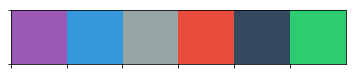

In [159]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set_palette(flatui)
sns.palplot(sns.color_palette())

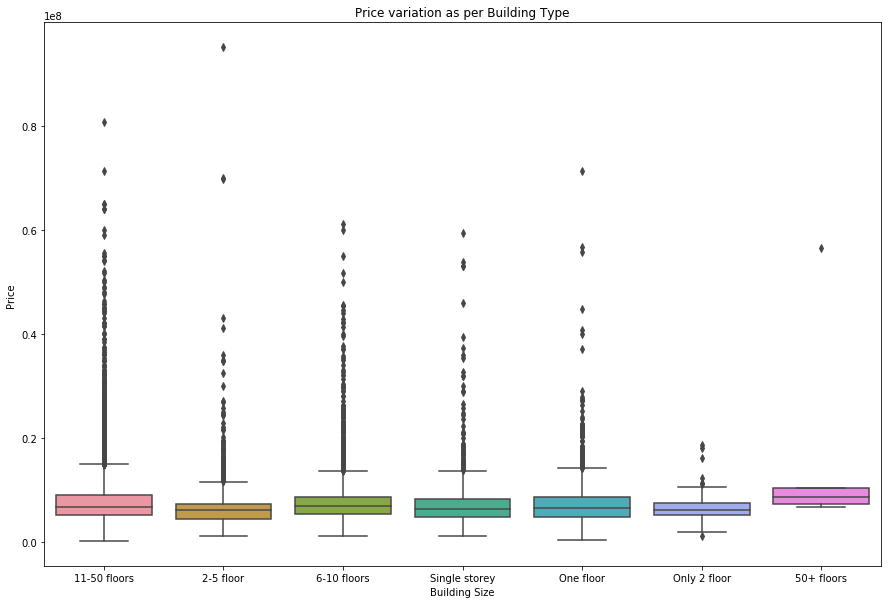

In [160]:
fig, ax = plt.subplots(figsize=(15,10))
b = sns.boxplot(x="build_size", y="price_doc", data=train)
plt.xlabel("Building Size")
plt.ylabel("Price ")
plt.title("Price variation as per Building Type")
plt.show(b)

Text(0.5, 1.0, 'Transaction count as per year and Product Type')

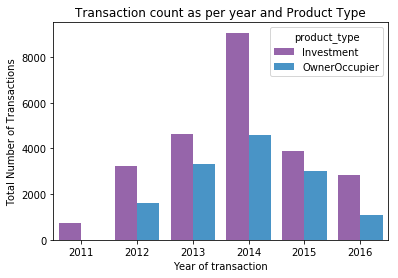

In [161]:
sns.countplot("trans_year",hue="product_type",data=df)
plt.xlabel("Year of transaction")
plt.ylabel("Total Number of Transactions")
plt.title("Transaction count as per year and Product Type")


Text(0.5, 1.0, 'Price v/s Full square')

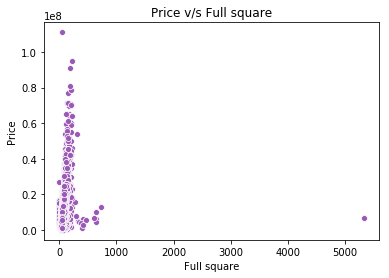

In [162]:
sns.scatterplot("full_sq","price_doc",data=train)
plt.xlabel("Full square")

plt.ylabel("Price")
plt.title("Price v/s Full square")


Text(0.5, 1.0, 'Price v/s Full square')

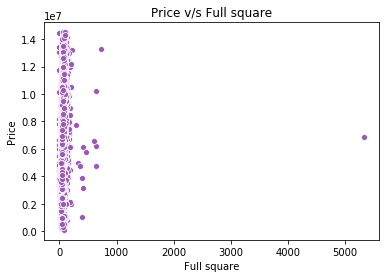

In [163]:
"""
Hence we can see that full_sq >300 is an outlier so lets remove this value and check our plot
"""

#The outliers should not be there for price_doc as well and hence removing it
train_new=train[train["price_doc"]<train[["price_doc"]].quantile(.95).values[0]]

sns.scatterplot("full_sq","price_doc",data=train_new)
plt.xlabel("Full square")
plt.ylabel("Price")
plt.title("Price v/s Full square")

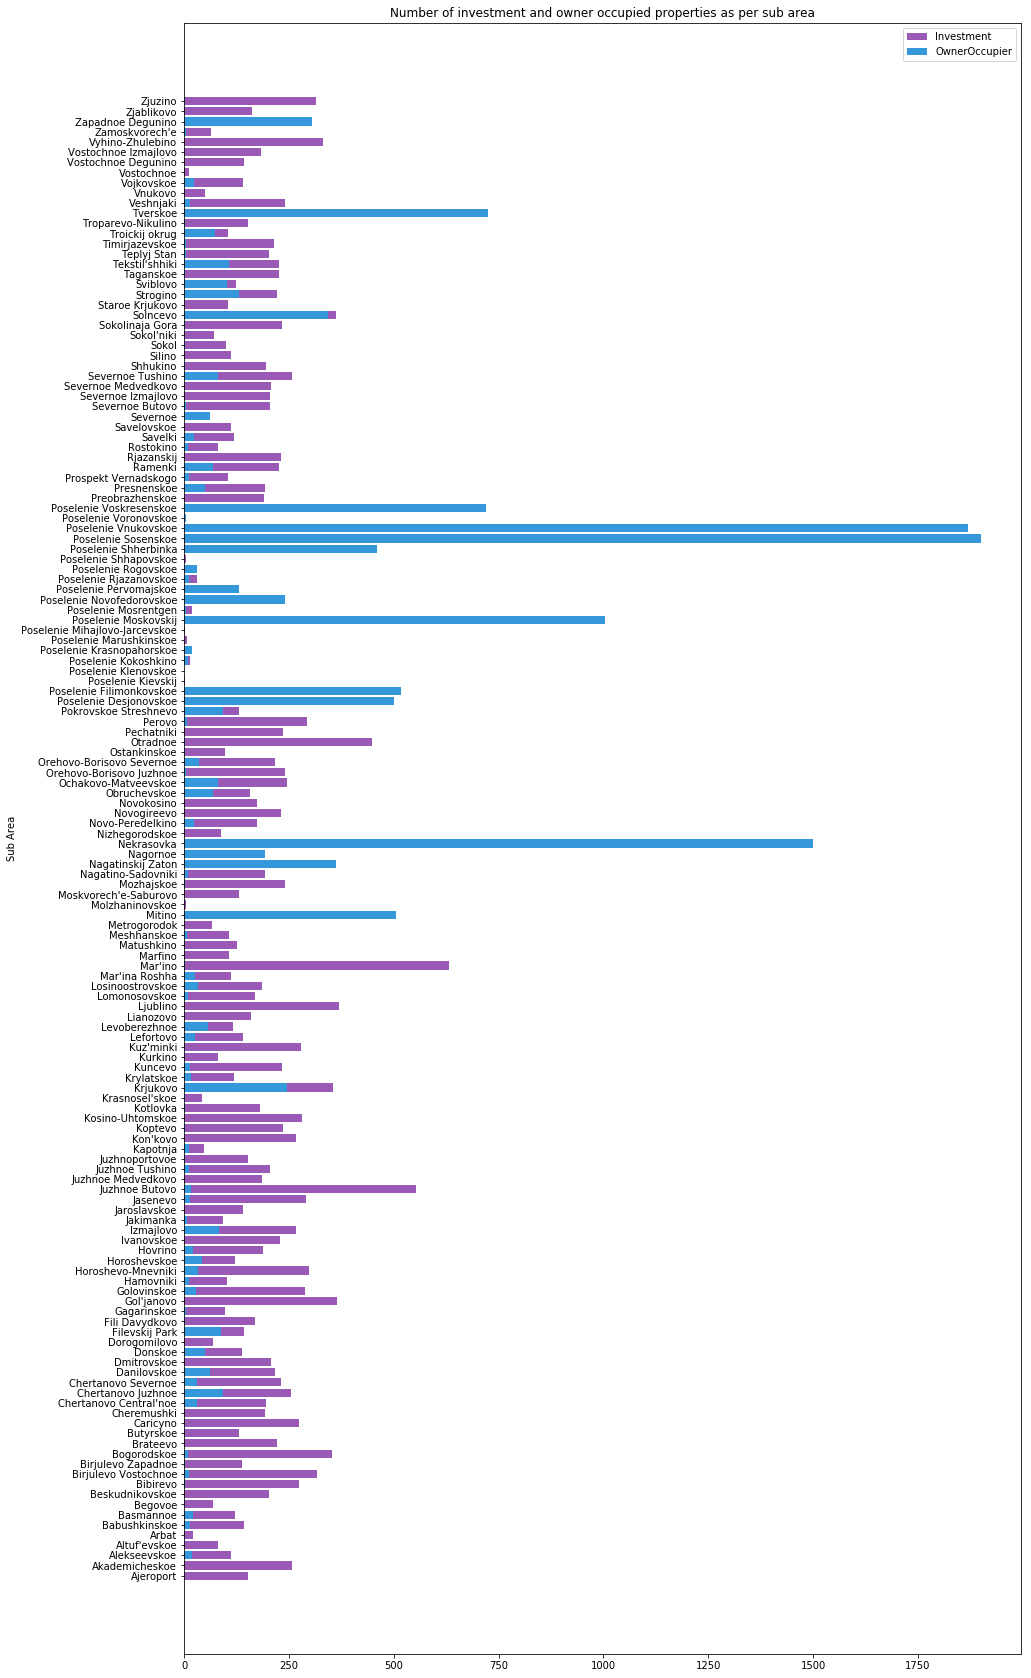

In [164]:
df_invest=df[df["product_type"]=="Investment"].groupby("sub_area")[["product_type"]].count()
df_owner=df[df["product_type"]=="OwnerOccupier"].groupby("sub_area")[["product_type"]].count()

fig, ax = plt.subplots(figsize=(15,30))
p1 = plt.barh(df_invest.index.values,df_invest.product_type)
p2 = plt.barh(df_owner.index.values,df_owner.product_type)
plt.ylabel('Sub Area')
plt.title('Number of investment and owner occupied properties as per sub area')
plt.legend((p1[0], p2[0]), ('Investment', 'OwnerOccupier'))

plt.show()

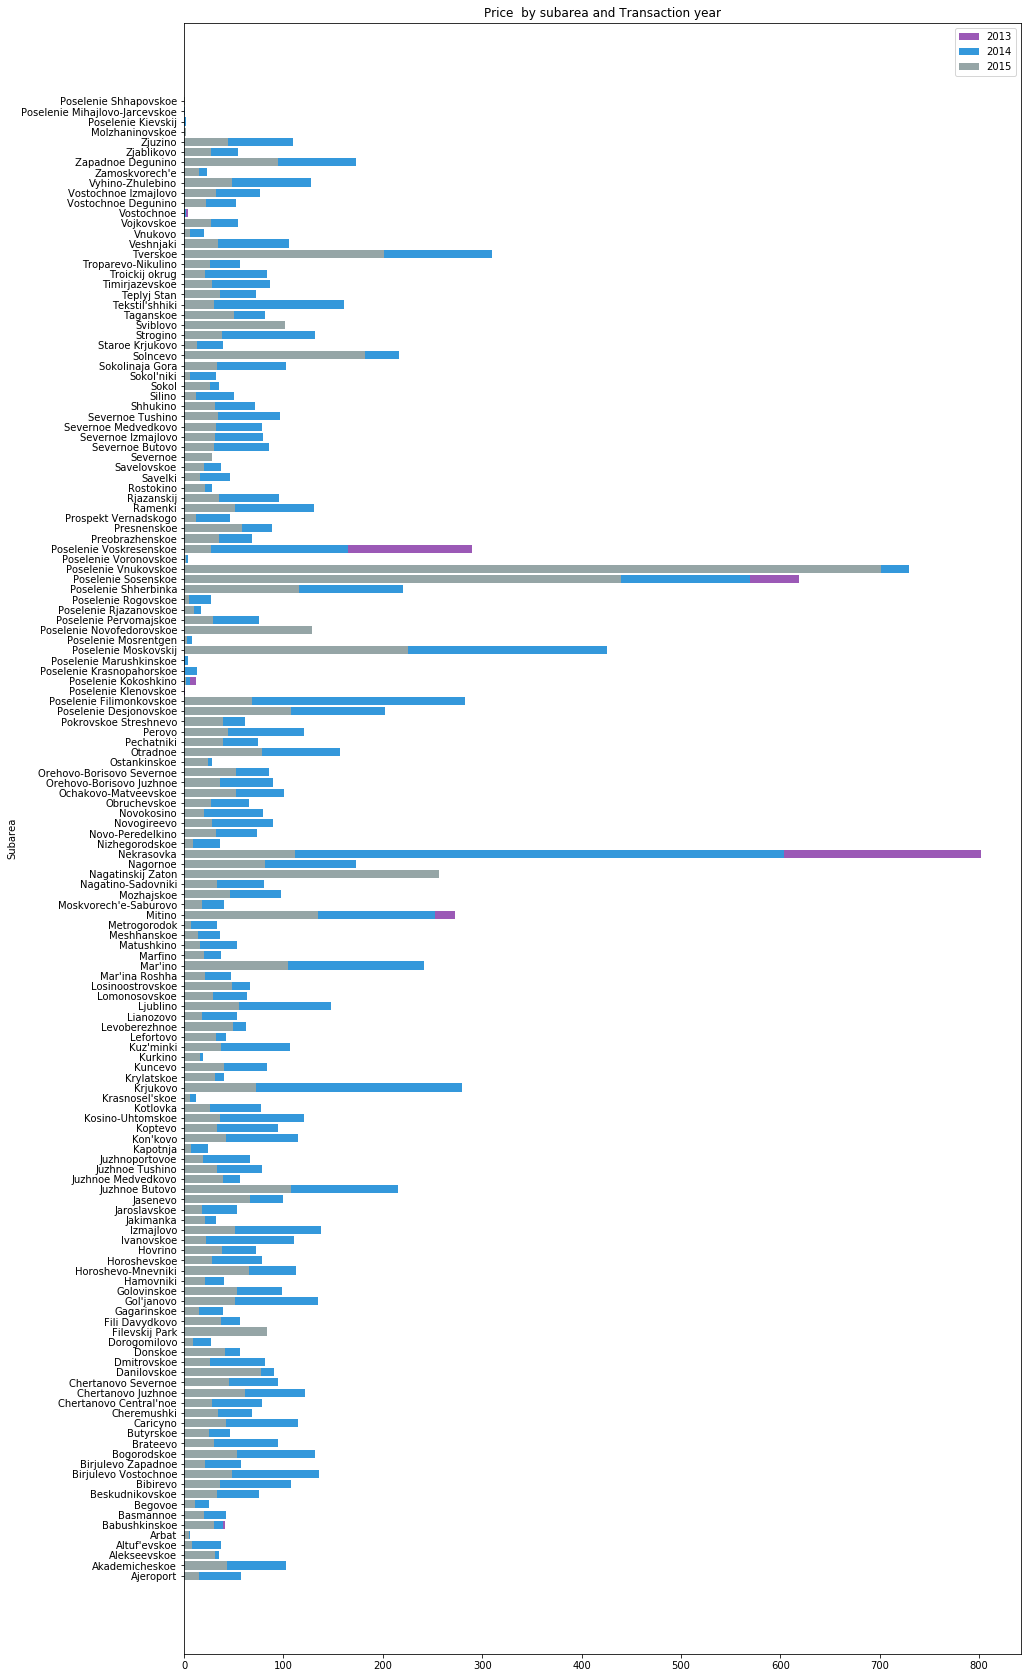

In [165]:
#df_2011=df[df["trans_year"]==2011].groupby("sub_area")[["id"]].count()
#df_2012=df[df["trans_year"]==2012].groupby("sub_area")[["id"]].count()
df_2013=df[df["trans_year"]==2013].groupby("sub_area")[["trans_year"]].count()
df_2014=df[df["trans_year"]==2014].groupby("sub_area")[["trans_year"]].count()
df_2015=df[df["trans_year"]==2015].groupby("sub_area")[["trans_year"]].count()

fig, ax = plt.subplots(figsize=(15,30))
#p2011 = plt.barh(df_2011.index.values,df_2011.id)
#p2012 = plt.barh(df_2012.index.values,df_2012.id)
p2013 = plt.barh(df_2013.index.values,df_2013.trans_year)
p2014 = plt.barh(df_2014.index.values,df_2014.trans_year)
p2015 = plt.barh(df_2015.index.values,df_2015.trans_year)
plt.ylabel('Subarea')
plt.title('Price  by subarea and Transaction year')
plt.legend((p2013[0], p2014[0],p2015[0]), ('2013', '2014','2015'))

#plt.legend((p2011[0], p2012[0],p2013[0], p2014[0],p2015[0]), ('2011', '2012','2013', '2014','2015'))

plt.show()

Text(0.5, 1.0, 'Count of houses per Building age group ')

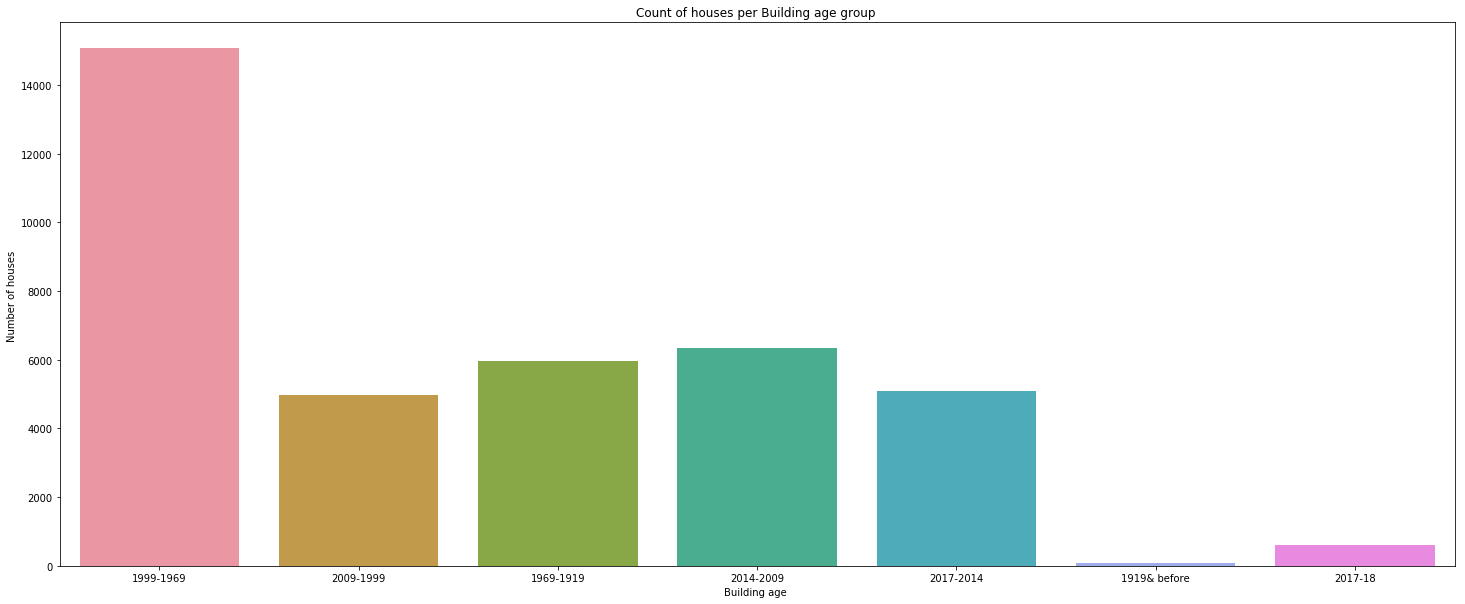

In [116]:
fig, ax = plt.subplots(figsize=(25,10))
a=sns.countplot("building_agetype",data=df,orient="v")
plt.ylabel("Number of houses ")
plt.xlabel("Building age ")
plt.title("Count of houses per Building age group ")



In [166]:
"""
#We removed some columns so lets see now how many columns have
#null values and if there are any lets replace it with mode
null_columns=df.columns[df.isnull().any()]
# basically just for the sake of keeping all columns and applying vif we replaced all null values with mode

for column in null_columns:
    df[column].fillna(df[column].mode()[0], inplace=True)
"""
    
    

'\n#We removed some columns so lets see now how many columns have\n#null values and if there are any lets replace it with mode\nnull_columns=df.columns[df.isnull().any()]\n# basically just for the sake of keeping all columns and applying vif we replaced all null values with mode\n\nfor column in null_columns:\n    df[column].fillna(df[column].mode()[0], inplace=True)\n'

<font color=#8F00FF>Lets Implement our model and see if we can predict price of houses </font>

In [167]:
"""
Since XGBoost works only on numeric data lets convert our object type data to numeric form and then apply our model

"""


'\nSince XGBoost works only on numeric data lets convert our object type data to numeric form and then apply our model\n\n'

In [ ]:
#Since there are so many columns and it takes a long time we have removed the below code ,
#one can run and see for reference

"""
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()
"""

In [ ]:
rs = np.random.RandomState(0)
#df = pd.DataFrame(rs.rand(10, 10))
corr = df[['green_part_5000', 'prom_part_5000', 'office_count_5000', 'office_sqm_5000','trc_count_5000', 'trc_sqm_5000', 'cafe_count_5000',
 'cafe_sum_5000_min_price_avg', 'cafe_sum_5000_max_price_avg','cafe_avg_price_5000', 'cafe_count_5000_na_price',
 'cafe_count_5000_price_500', 'cafe_count_5000_price_1000','cafe_count_5000_price_1500', 'cafe_count_5000_price_2500', 'cafe_count_5000_price_4000', 'cafe_count_5000_price_high',
 'big_church_count_5000', 'church_count_5000', 'mosque_count_5000',
 'leisure_count_5000', 'sport_count_5000', 'market_count_5000']].corr()
corr.style.background_gradient(cmap='coolwarm')


In [ ]:

"""
df.drop(["trc_count_1500","cafe_count_1500","cafe_count_1500_na_price","cafe_count_1500_price_500","cafe_count_1500_price_1000","cafe_count_1500_price_1500","cafe_count_1500_price_2500","cafe_count_1500_price_4000","cafe_count_1500_price_high","big_church_count_1500","church_count_1500","mosque_count_1500","leisure_count_1500","sport_count_1500","market_count_1500"],axis=1,inplace=True)
df.drop(["culture_objects_top_25_raion","culture_objects_top_25","thermal_power_plant_raion","incineration_raion","oil_chemistry_raion","radiation_raion","railroad_terminal_raion","big_market_raion","nuclear_reactor_raion","detention_facility_raion","trc_count_1000","cafe_count_1000","cafe_count_1000_na_price","cafe_count_1000_price_500","cafe_count_1000_price_1000","cafe_count_1000_price_1500","cafe_count_1000_price_2500","cafe_count_1000_price_4000","cafe_count_1000_price_high","big_church_count_1000","church_count_1000","mosque_count_1000","leisure_count_1000","sport_count_1000","market_count_1000",],axis=1,inplace=True)

df.drop(["office_count_3000","trc_count_3000","cafe_count_3000","cafe_sum_3000_min_price_avg","cafe_sum_3000_max_price_avg","cafe_avg_price_3000","cafe_avg_price_3000","cafe_count_3000_na_price","cafe_count_3000_price_500","cafe_count_3000_price_1000","cafe_count_3000_price_1500","cafe_count_3000_price_2500","cafe_count_3000_price_4000","cafe_count_3000_price_high","big_church_count_3000","church_count_3000","mosque_count_3000","leisure_count_3000","sport_count_3000","market_count_3000"],axis=1,inplace=True)
df.drop(["office_count_2000","trc_count_2000","cafe_count_2000","cafe_sum_2000_min_price_avg","cafe_sum_2000_max_price_avg","cafe_avg_price_2000","cafe_count_2000_na_price","cafe_count_2000_price_500","cafe_count_2000_price_1000","cafe_count_2000_price_1500","cafe_count_2000_price_2500","cafe_count_2000_price_4000","cafe_count_2000_price_high","big_church_count_2000","church_count_2000","mosque_count_2000","leisure_count_2000","sport_count_2000","market_count_2000"],axis=1,inplace=True)
df.drop(["male_f","female_f","young_all","young_male","young_female","work_all","work_male","work_female","ekder_all",
             "ekder_male","ekder_female","0_6_all","0_6_male","0_6_female","7_14_all","7_14_male","7_14_female","0_17_all",
              "0_17_male","0_17_female","16_29_all","16_29_male","16_29_female","0_13_all","0_13_male","0_13_female"],
             axis=1,inplace=True)

df.drop(["office_count_500","office_sqm_500","trc_count_500","trc_sqm_500","cafe_count_500","cafe_count_500_na_price","cafe_count_500_price_500","cafe_count_500_price_1000","cafe_count_500_price_1500","cafe_count_500_price_2500","cafe_count_500_price_4000","cafe_count_500_price_high","big_church_count_500","mosque_count_500","leisure_count_500","sport_count_500","market_count_500"],axis=1,inplace=True)
df.drop(["cafe_count_5000_na_price","cafe_count_5000_price_500","cafe_count_5000_price_1000","cafe_count_5000_price_1500","cafe_count_5000_price_2500","cafe_count_5000_price_4000","cafe_count_5000_price_high","big_church_count_5000","church_count_5000","leisure_count_5000","office_count_5000","office_sqm_5000"],axis=1,inplace=True)

"""

In [117]:
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

KeyboardInterrupt: 

In [168]:
a=list(df.select_dtypes(include=['object']).dtypes.index.values)

for i in a :
    # use pd.concat to join the new columns with your original dataframe
    df_xg = pd.concat([df,pd.get_dummies(df[i], prefix='sub_area',drop_first=True)],axis=1,)

    # now drop the original 'country' column (you don't need it anymore)
    #df_xg.drop([i],axis=1, inplace=True)

In [169]:
df_xg.columns.values

array(['0_13_all', '0_13_female', '0_13_male', '0_17_all', '0_17_female',
       '0_17_male', '0_6_all', '0_6_female', '0_6_male', '16_29_all',
       '16_29_female', '16_29_male', '7_14_all', '7_14_female',
       '7_14_male', 'ID_big_road1', 'ID_big_road2', 'ID_bus_terminal',
       'ID_metro', 'ID_railroad_station_avto', 'ID_railroad_station_walk',
       'ID_railroad_terminal', 'additional_education_km',
       'additional_education_raion', 'area_m', 'basketball_km',
       'big_church_count_1000', 'big_church_count_1500',
       'big_church_count_2000', 'big_church_count_3000',
       'big_church_count_500', 'big_church_count_5000', 'big_church_km',
       'big_market_km', 'big_market_raion', 'big_road1_1line',
       'big_road1_km', 'big_road2_km', 'build_count_1921-1945',
       'build_count_1946-1970', 'build_count_1971-1995',
       'build_count_after_1995', 'build_count_before_1920',
       'build_count_block', 'build_count_brick', 'build_count_foam',
       'build_count_fram

In [170]:
df_xg["log_price"]=np.log1p(df_xg["price_doc"])
                            
new_train=df_xg[df_xg.id<30474]
new_train.shape
new_test=df_xg[df_xg.id>30473]
new_test.shape

(7662, 319)

In [173]:

x=new_train.drop(["price_doc","log_price"],axis=1).select_dtypes(exclude=['object'])
y=new_train["log_price"]

x -= x.mean(axis=0)
x /= x.std(axis=0)


x_test=new_test.drop(["price_doc","log_price"],axis=1).select_dtypes(exclude=['object'])
y_test=new_test["log_price"]

x_test -= x_test.mean(axis=0)
x_test /= x_test.std(axis=0)

x_train,x_val,y_train,y_val=train_test_split(x, y, test_size=0.33, random_state=42)


In [175]:
"""
Its better to convert data into Dmatrix before applying xgb 
"""
dtrain = xgb.DMatrix(data=x_train,label= y_train)
dval = xgb.DMatrix(data=x_val, label=y_val)
dtest = xgb.DMatrix(data=x_test, label=y_test)

"""
Intialising XGB model and then fitting train dataa
"""

xgb_params = {
    'eta': 0.05,
    'max_depth': 6,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

# Uncomment to tune XGB `num_boost_rounds`
partial_model = xgb.train(xgb_params, dtrain, num_boost_round=1000, evals=[(dval, 'val')],
                       early_stopping_rounds=20, verbose_eval=20)

num_boost_round = partial_model.best_iteration

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	val-rmse:14.3668
Will train until val-rmse hasn't improved in 20 rounds.
[20]	val-rmse:5.17517
[40]	val-rmse:1.91248
[60]	val-rmse:0.81435
[80]	val-rmse:0.520209
[100]	val-rmse:0.46569
[120]	val-rmse:0.456183
[140]	val-rmse:0.454334
[160]	val-rmse:0.453714
[180]	val-rmse:0.453336
[200]	val-rmse:0.453272
[220]	val-rmse:0.453343
Stopping. Best iteration:
[207]	val-rmse:0.453247



In [176]:
num_boost_round = partial_model.best_iteration
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_round)

In [177]:
ylog_pred = model.predict(dtest)
y_pred = np.exp(ylog_pred) - 1

df_sub = pd.DataFrame({'id': new_test.id, 'price_doc': y_pred})

df_sub.to_csv('sub.csv', index=False)

In [ ]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=dtrain, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

In [ ]:
cv_results.head()

In [ ]:
"""
Plotting the feature importance graph
"""

fig, ax = plt.subplots(1, 1, figsize=(8, 16))
xgb.plot_importance(partial_model, max_num_features=50, height=0.5, ax=ax)

In [ ]:
feature_important = partial_model.get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

"""
Lets create a dataframe with all the details about feature importance as per our model 
"""
data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)


In [ ]:
#Fetching top 50 features for our model building 
(data.sort_values(by=['score'], ascending=False)[:50]).index.values



In [ ]:
"""
We selected top 50 fetaures and then tried to fit linear model
"""


z=df[['full_sq', 'floor', 'max_floor', 'build_year', 'trans_year',
       'num_room', 'state', 'railroad_km', 'metro_min_avto',
       'cemetery_km', 'public_healthcare_km', 'radiation_km',
       'kindergarten_km', 'green_zone_km', 'industrial_km', 'park_km',
       'workplaces_km', 'swim_pool_km', 'mosque_km', 'nuclear_reactor_km',
       'school_km', 'big_church_km', 'material',
       'public_transport_station_min_walk', 'green_part_500',
       'additional_education_km', 'metro_km_avto', 'university_km',
       'ttk_km', 'cafe_count_5000', 'catering_km', 'metro_min_walk',
       'water_km', 'area_m', 'theater_km', 'ice_rink_km', 'Building_Age',
       'green_part_1500', 'shopping_centers_km', 'big_road2_km',
       'fitness_km', 'stadium_km', 'church_synagogue_km',
       'zd_vokzaly_avto_km', 'big_market_km', 'bus_terminal_avto_km',
       'hospice_morgue_km', 'green_part_1000', 'ts_km',
       'railroad_station_avto_km']].select_dtypes(exclude=['object'])
y=df["price_doc"]

from sklearn.preprocessing import StandardScaler
standradize=True
if standradize:
    print('Standradizing the data..')
    #inf values can result from squaring
    scaler = StandardScaler()
    
    z= scaler.fit_transform(z)

    print('Data Standradized!')
    
x_train,x_test,y_train,y_test=train_test_split(z, y, test_size=0.33, random_state=42)
#wo_null1.columns.values

In [ ]:
"""
Fitting linear regression on our dataset
"""

model=LinearRegression()

model.fit(x_train,y_train)

In [ ]:
pred=model.predict(x_test)

print("mse",mean_squared_error(pred,y_test))
print("mse",mean_absolute_error(pred,y_test))


In [ ]:
"""
Lets try and analyse our target variable and understand if its skewed or normally distributed 
"""

sns.distplot(train['price_doc'] , fit=norm);

"""
Finding mu and sigma after fitting it to a normalized form 
"""
(mu, sigma) = norm.fit(train['price_doc'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')


In [ ]:
"""
Lets also draw the qqplot of the same , basically qqplot are 
Q–Q (quantile-quantile) plot is a probability plot, which is a graphical method for comparing two probability 
distributions by plotting their quantiles against each other.
"""
fig = plt.figure()
res = stats.probplot(train['price_doc'], plot=plt)
plt.show()

In [ ]:
"""
We could see that the price_doc value is right skewed
and as (linear) models work well on normally distributed data , 
we need to transform this variable and make it more normally distributed. 
Lets try log transformation and understand if it improved model perfomance
"""

sns.distplot(new_train["log_price"], fit=norm);

"""
Lets try and analyse our  transformed price and understand if its skewed or normally distributed 
"""
(mu, sigma) = norm.fit(new_train["log_price"])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Log Price distribution')

In [ ]:
"""
Lets also draw the qqplot of the transformed price
"""
fig = plt.figure()
res = stats.probplot(new_train["log_price"], plot=plt)
plt.show()

In [ ]:
"""
Lets apply regression now on Logtransformmed data
"""

In [ ]:

z=new_train[['full_sq', 'floor', 'max_floor', 'build_year', 'trans_year',
       'num_room', 'state', 'railroad_km', 'metro_min_avto',
       'cemetery_km', 'public_healthcare_km', 'radiation_km',
       'kindergarten_km', 'green_zone_km', 'industrial_km', 'park_km',
       'workplaces_km', 'swim_pool_km', 'mosque_km', 'nuclear_reactor_km',
       'school_km', 'big_church_km', 'material',
       'public_transport_station_min_walk', 'green_part_500',
       'additional_education_km', 'metro_km_avto', 'university_km',
       'ttk_km', 'cafe_count_5000', 'catering_km', 'metro_min_walk',
       'water_km', 'area_m', 'theater_km', 'ice_rink_km', 'Building_Age',
       'green_part_1500', 'shopping_centers_km', 'big_road2_km',
       'fitness_km', 'stadium_km', 'church_synagogue_km',
       'zd_vokzaly_avto_km', 'big_market_km', 'bus_terminal_avto_km',
       'hospice_morgue_km', 'green_part_1000', 'ts_km',
       'railroad_station_avto_km']].select_dtypes(exclude=['object'])
y=new_train["log_price"]

from sklearn.preprocessing import StandardScaler
standradize=True
if standradize:
    print('Standradizing the data..')
    #inf values can result from squaring
    scaler = StandardScaler()
    
    z= scaler.fit_transform(z)

    print('Data Standradized!')
    
x_train,x_test,y_train,y_test=train_test_split(z, y, test_size=0.33, random_state=42)
    
#x_train,x_test,y_train,y_test=train_test_split(z, y, test_size=0.33, random_state=42)
#wo_null1.columns.values

In [ ]:
"""
Fitting linear regression on our dataset
"""

model=LinearRegression()

model.fit(x_train,y_train)

In [ ]:
pred=model.predict(x_test)

print("rmse",sqrt(mean_squared_error(pred,y_test)))
print("mse",mean_absolute_error(pred,y_test))
print("Rsquare values",r2_score(pred,y_test))

In [ ]:
pred_price=np.expm1(pred)
y_test_price=np.expm1(y_test)

print("mse",mean_squared_error(pred_price,y_test_price))
print("mse",mean_absolute_error(pred_price,y_test_price))
print("Rsquare values",r2_score(pred_price,y_test_price))

In [ ]:
"""
Lets try implementing Polynomial regression 
"""
  
poly = PolynomialFeatures(degree = 2) 
X_poly = poly.fit_transform(x_train) 

poly.fit(X_poly, y_train) 
lin2 = LinearRegression() 
lin2.fit(X_poly, y_train) 

In [ ]:
pred=lin2.predict(poly.fit_transform(x_test)) 
print("Mean absolute error",mean_absolute_error(pred,y_test))
print("Rsquare values",r2_score(pred,y_test))

In [ ]:
"""
Lets try implementing elasticnet i.e combination of lasso and ridge regresion 
and see if there is any improvement in our model
"""

regr = ElasticNet(random_state=0)
regr.fit(x_train, y_train)
ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=0, selection='cyclic', tol=0.0001, warm_start=False)
#print(regr.coef_) 
print(regr.intercept_) 
pred=regr.predict(x_test)
print("Root Mean square error",sqrt(mean_squared_error(pred,y_test)))
print("Rsquare values",r2_score(pred,y_test))

In [ ]:
#Again lets implement xgboost on selected features along with Log transformed price value

In [ ]:
"""
We will implement k fold cross validation with Linear model as its a better way to train
Below is the sample copied code for reference 
"""

x_train, x_test, y_train, y_test = train_test_split(z,y,test_size=0.2)
clf = linear_model.Lasso()
clf.fit(x_train,y_train)
accuracy = clf.score(x_test,y_test)
print("accuracy",accuracy)
pred=clf.predict(x_test)
print("Mean absolute error",mean_absolute_error(pred,y_test))


scores = cross_val_score(clf, x_train, y_train, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
print(rmse_scores)

In [ ]:
"""
Its better to convert data into Dmatrix before applying xgb 
"""
dtrain = xgb.DMatrix(data=x_train,label= y_train)
dval = xgb.DMatrix(data=x_test, label=y_test)

"""
Intialising XGB model and then fitting train dataa
"""

xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

# Uncomment to tune XGB `num_boost_rounds`
partial_model = xgb.train(xgb_params, dtrain, num_boost_round=1000, evals=[(dval, 'val')],
                       early_stopping_rounds=20, verbose_eval=20)

num_boost_round = partial_model.best_iteration

In [ ]:

pred=partial_model.predict(dval)
print("Mean absolute error",mean_absolute_error(pred,y_test))
print("rmse",sqrt(mean_squared_error(pred,y_test)))
print("Rsquare values",r2_score(pred,y_test))

In [ ]:

test1=new_test[['full_sq', 'floor', 'Building_Age', 'max_floor', 'trans_year',
       'kindergarten_km', 'state', 'metro_min_avto', 'num_room',
       'public_transport_station_km', 'park_km', 'green_zone_km',
       'railroad_km', 'school_km', 'industrial_km', 'water_km',
       'catering_km', 'metro_km_avto', 'additional_education_km',
       'cemetery_km', 'build_year', 'big_road1_km', 'fitness_km',
       'public_healthcare_km', 'material', 'mosque_km', 'metro_min_walk',
       'big_market_km', 'hospice_morgue_km', 'radiation_km',
       'big_road2_km', 'water_treatment_km', 'green_part_1000',
       'thermal_power_plant_km', 'shopping_centers_km', 'area_m',
       'swim_pool_km', 'stadium_km', 'market_shop_km',
       'railroad_station_walk_km', 'ts_km', 'theater_km', 'preschool_km',
       'office_km', 'green_part_500', 'power_transmission_line_km',
       'nuclear_reactor_km', 'prom_part_5000', 'zd_vokzaly_avto_km',
       'bus_terminal_avto_km']].select_dtypes(exclude=['object'])

from sklearn.preprocessing import StandardScaler
standradize=True
if standradize:
    print('Standradizing the data..')
    #inf values can result from squaring
    scaler = StandardScaler()
    
    test1= scaler.fit_transform(test1)

    print('Data Standradized!')
dval1 = xgb.DMatrix(data=test1, label=y_test)
print(test1.shape)

In [ ]:
print(new_test.shape)
test.shape

In [ ]:
"""
pred1=partial_model.predict(dval1)
#pred2=pd.DataFrame(pred1)
df_sub = pd.DataFrame({'id': test["id"], 'price_doc': pred1})

df_sub.to_csv('sub.csv', index=False)
"""

In [ ]:
df_sub.shape